In [36]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os

In [37]:
def F_kernel(q): 
    if q>=0 and q<1:
        return 1-1.5*q**2+0.75*q**3
    if q>=1 and q<2:
        return 0.25*(2-q)**3
    if q>=2:
        return 0

def F_kernel_p(q): 
    if q>=0 and q<1:
        return -3.*q + 3*0.75*q**2
    if q>=1 and q<2:
        return 0.75*(2-q)**2*(-1)
    if q>=2:
        return 0
    
def W_1order(dist, h):
    q = dist/h
    C = 2./3.
    return C*F_kernel(q)/h**1

def W_1order_p(ra, rb, h):
    q = abs(ra-rb)/h
    C = 2./3.
    if ra == rb: 
        rhat = 0
    else:
        rhat = (ra-rb)/abs(ra-rb)
    return rhat*C*F_kernel_p(q)/h**2

In [121]:
def get_density(particles):
    n = len(particles)
    for i in range(n):
        particles[i, DEN] = 0
        for j in range(n):
            particles[i, DEN] += particles[j, MAS]*W_1order(abs(particles[i,X1]-particles[j,X1]), particles[i,LEN])
    return particles

def eos_iso(rho, cs = 1.0):
    p = cs**2*rho
    return p

def get_pressure(particles, eos=eos_iso):
    n = len(particles)
    for i in range(n):
        particles[i, PRE] = eos(particles[i, DEN], particles[i, SPE])
    return particles

def get_visco(para, parb, alpha = 1, beta = 2):
    vab = para[VEL1] - parb[VEL1]
    if para[X1] == parb[X1]: 
        rab_hat = 0
    else:
        rab_hat = (para[X1] - parb[X1])/abs(para[X1] - parb[X1])
    vdotr = vab*rab_hat
    if vdotr < 0:
        nu_siga = alpha * para[SPE] - beta*vdotr
        nu_sigb = alpha * parb[SPE] - beta*vdotr
        qa = -0.5*para[DEN]*nu_siga*vdotr
        qb = -0.5*parb[DEN]*nu_sigb*vdotr
    else:
        qa = 0
        qb = 0
    return qa, qb

def smoothing(particles):
    hfact = 1.2
    for i in range(len(particles)):
        particles[i, LEN] = hfact*(particles[i,MAS]/particles[i,DEN])
    return particles

def get_accel(particles):
    mass = particles[:,MAS]
    p = particles[:,PRE]
    rho = particles[:,DEN]
    r = particles[:,X1]
    h = particles[:,LEN]
    for a in range(len(particles)):
        acc = 0
        for b in range(len(particles)):
            qa, qb = get_visco(particles[a], particles[b])
            acc += - mass[b]*(  ((p[a]+qa)/rho[a]**2)*W_1order_p(r[a], r[b], h[a]) 
                              + ((p[b]+qb)/rho[b]**2)*W_1order_p(r[a], r[b], h[b]) )
        particles[a, ACC1] = acc
    return particles

def derivs(particles, nghost):
    n_smooth = 3
    particles = set_ghosts(particles, nghost, L)
    particles = get_density(particles)
    for i in range(n_smooth):
        particles = smoothing(particles)
        particles = get_density(particles)
    particles = get_pressure(particles)
    particles = get_accel(particles)
    return particles

In [39]:
def integral(particles, nghost, dt):
    r = np.copy(particles[:,X1])
    vel = np.copy(particles[:,VEL1])
    vhalf = np.copy(vel)
    for a in range(nghost, len(particles)-nghost):
        acc = particles[a, ACC1]
        particles[a, X1] = r[a] + dt*vel[a] + 0.5*dt**2*acc
        vhalf[a] = vel[a] + 0.5*dt*acc
    particles = derivs(particles, nghost)
    for a in range(nghost, len(particles)-nghost):
        particles[a, VEL1] = vhalf[a] + 0.5*dt*particles[a, ACC1]
    return particles

In [40]:
#index
X1 = 0      # position x1
VEL1 = 1    # velocity in x1 direction 
MAS = 2     # mass 
LEN = 3     # smoothing length
DEN = 4     # density
ENE = 5     # internal energy (u) 
PRE = 6     # pressure 
SPE = 7     # sound speed
ACC1 = 8    # acceleration 
def setup(n, xmin, xmax, rho0, cs, nghost = 0):   # new setup that can include ghost particles.
    particles = np.zeros((n+2*nghost, 9))
    dx = (xmax - xmin)/n
    m0 = rho0*dx
    for i in range(nghost, n+nghost):
        particles[i, X1] = xmin + 0.5*dx + (i-nghost)*dx
        particles[i, MAS] = m0 
        particles[i, VEL1] = 1e-2*cs*np.sin(4.*np.pi*particles[i, X1])
        particles[i, LEN] = 1.2*dx
        particles[i, SPE] = cs
    return particles

def set_ghosts(particles, nghost, L):
    for i in range(nghost):
        particles[i] = particles[-2*nghost+i]
        particles[i, X1] = particles[i, X1] - L
        particles[-nghost+i] = particles[nghost+i]
        particles[-nghost+i, X1] = particles[-nghost+i, X1] + L
    return particles

In [116]:
# output data
def write_particles(particles, t, filename):
    with open(filename, 'w') as file:
        file.write(str(t) + '\n')
        for particle in particles:
            file.write(' '.join(map(str, particle)) + '\n')
            
def read_particles(filename):
    particles = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        t = float(lines[0])
        for line in lines[1:]:
            particle = list(map(float, line.split()))
            particles.append(particle)
    return t, np.array(particles)

def write_time(filename, keys, values):
    if (abs(values[0] - 0) < 1e-6) and os.path.exists(filename):
        os.remove(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    file_exists = os.path.isfile(filename)
    with open(filename, 'a') as file:
        if not file_exists:
            # 写入表头
            for key in keys:
                file.write(key+"\t")
            file.write("\n")
        # 写入数据
        for value in values:
            file.write(str(value)+"\t")
        file.write("\n")
        

In [88]:
def sim(particles, nghost, t0, tmax, dt, dtoutput, output_path = "./"):
    t = t0
    output_index = 0
    toutput = t0
    keys = ["time", "kinetic energy"]
    
    print("t=", format(t, ".2f"), end="\r")
    write_time(output_path+"time.txt", keys, [t, get_kinetic_energy(particles, nghost)])
    filename = output_path+"output."+ str(output_index).zfill(5) + ".txt"
    write_particles(particles, t, filename)
    toutput = toutput + dtoutput
    output_index += 1
    while t < tmax:
        if t + dt >= tmax: 
            dt = tmax - t
            toutput = tmax
        t = t + dt
        particles = integral(particles, nghost, dt)
        particles = derivs(particles, nghost)
        write_time(output_path+"time.txt", keys, [t, get_kinetic_energy(particles, nghost)])
        if abs(t-toutput)<0.5*dt:
            print("t=", format(t, ".2f"), end="\r")
            filename = output_path+"output."+ str(output_index).zfill(5) + ".txt"
            write_particles(particles, t, filename)
            toutput = toutput + dtoutput
            output_index += 1
    return particles

In [80]:
def get_kinetic_energy(particles, nghost):
    kn = 0
    for i in range(nghost, len(particles)-nghost):
        kn += 0.5*particles[i,MAS]*particles[i,VEL1]**2
    return kn

In [81]:
n = 100
xmin = 0
xmax = 1.
L = xmax - xmin
rho0 = 1.0
cs = 0.1
nghost = 10
particles = setup(n, xmin, xmax, rho0, cs, nghost)
particles = derivs(particles, nghost)

t0 = 0
tmax = 5
dt = 0.06
toutput = 0.
dtoutput = 1.

t = t0

output_path = "./test001/"
particles = sim(particles, nghost, t0, tmax, dt, dtoutput, output_path = "./test001/")

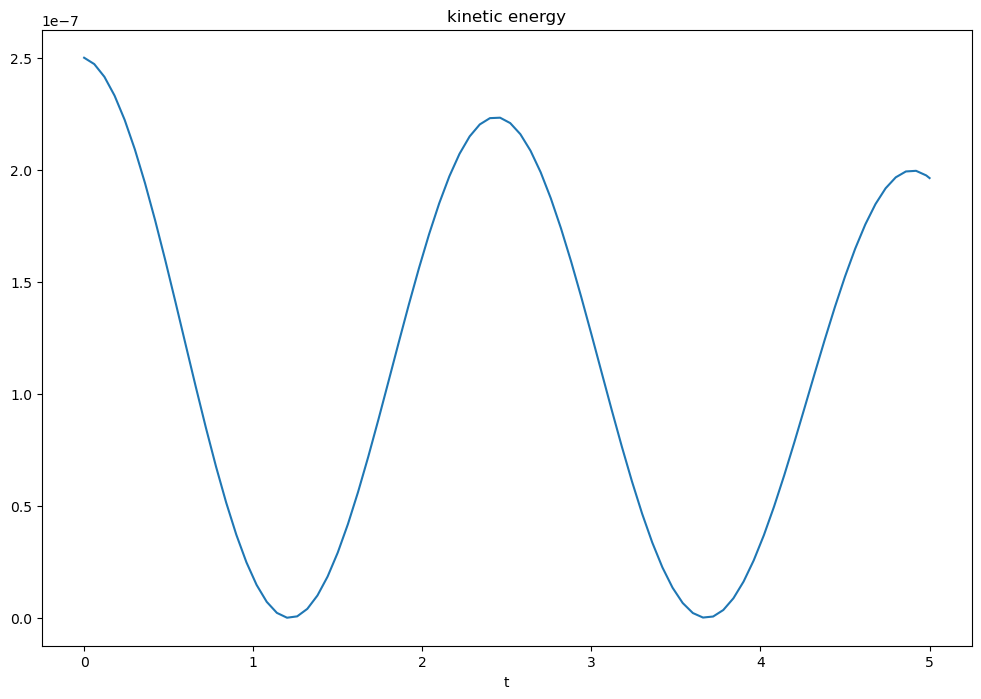

In [83]:
data = np.loadtxt("./test001/time.txt", skiprows=1)
t_list = data[:,0]
KE_list = data[:,1]
# plot kinetic energy of the particles
plt.figure(figsize = (12,8))
plt.plot(t_list, KE_list)
plt.title("kinetic energy")
plt.xlabel("t")
plt.show()

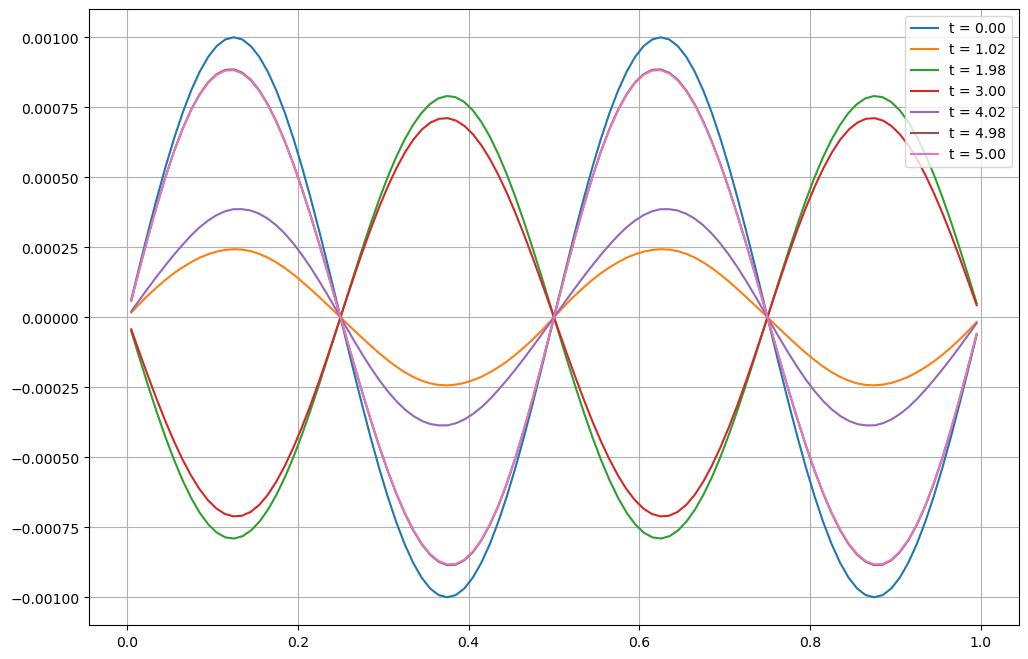

In [108]:
plt.figure(figsize = (12,8))
output_path = "./test001/"
for i in range(7):
    filename = output_path+"output."+ str(i).zfill(5) + ".txt"
    t, particles = read_particles(filename)
    act_par = particles[nghost:-nghost]
    plt.plot(act_par[:, X1], act_par[:, VEL1], label = "t = "+ format(t, ".2f"))
plt.grid()
plt.legend()
plt.show()

In [114]:
# 13
def setup(nleft, x0, xmin, xmax, rholeft, rhoright, cs, nghost = 0):
    particles = np.zeros((nleft+nghost, 9))
    particle = np.copy(particles[0])
    dxleft = (x0 - xmin)/nleft
    m0 = rholeft*dxleft
    for i in range(len(particles)):
        particles[i, X1] = xmin + 0.5*dxleft + (i-nghost)*dxleft
        particles[i, MAS] = m0 
        particles[i, VEL1] = 0.
        particles[i, LEN] = 1.2*dxleft
        particles[i, SPE] = cs
    dxright = m0/rhoright
    x = x0 + 0.5*dxright
    while x <= xmax:
        particle[X1] = x
        particle[MAS] = m0 
        particle[VEL1] = 0.
        particle[LEN] = 1.2*dxright
        particle[SPE] = cs
        particles = np.insert(particles, len(particles), particle, 0)
        x = x + dxright
    for i in range(nghost):
        particle[X1] = x
        particle[MAS] = m0 
        particle[VEL1] = 0.
        particle[LEN] = 1.2*dxright
        particle[SPE] = cs
        particles = np.insert(particles, len(particles), particle, 0)
        x = x + dxright
    return particles

def set_ghosts(particles, nghost, L):
    for i in range(nghost):
        particles[i] = particles[i]
        particles[-nghost+i] = particles[-nghost+i]
    return particles

In [122]:
nleft = 100
xmin = -0.5
xmax = 0.5
x0 = 0
L = xmax - xmin
rholeft = 1.0
rhoright = 0.1
cs = 0.1
nghost = 6
particles = setup(nleft, x0, xmin, xmax, rholeft, rhoright, cs, nghost)
particles = derivs(particles, nghost)

t0 = 0
tmax = 2
dt = 0.002
toutput = 0.
dtoutput = 0.2

t = t0

output_path = "./sod001/"
particles = sim(particles, nghost, t0, tmax, dt, dtoutput, output_path)

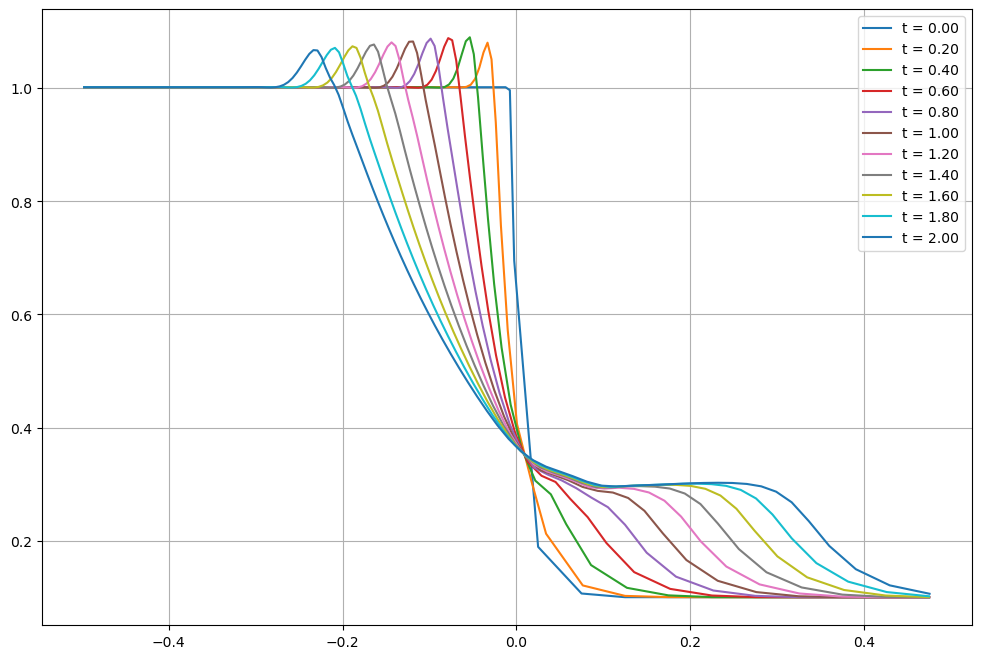

In [128]:
plt.figure(figsize = (12,8))
output_path = "./sod001/"
for i in range(11):
    filename = output_path+"output."+ str(i).zfill(5) + ".txt"
    t, particles = read_particles(filename)
    act_par = particles[nghost:-nghost]
    plt.plot(act_par[:, X1], act_par[:, DEN], label = "t = "+ format(t, ".2f"))
plt.grid()
plt.legend()
plt.show()

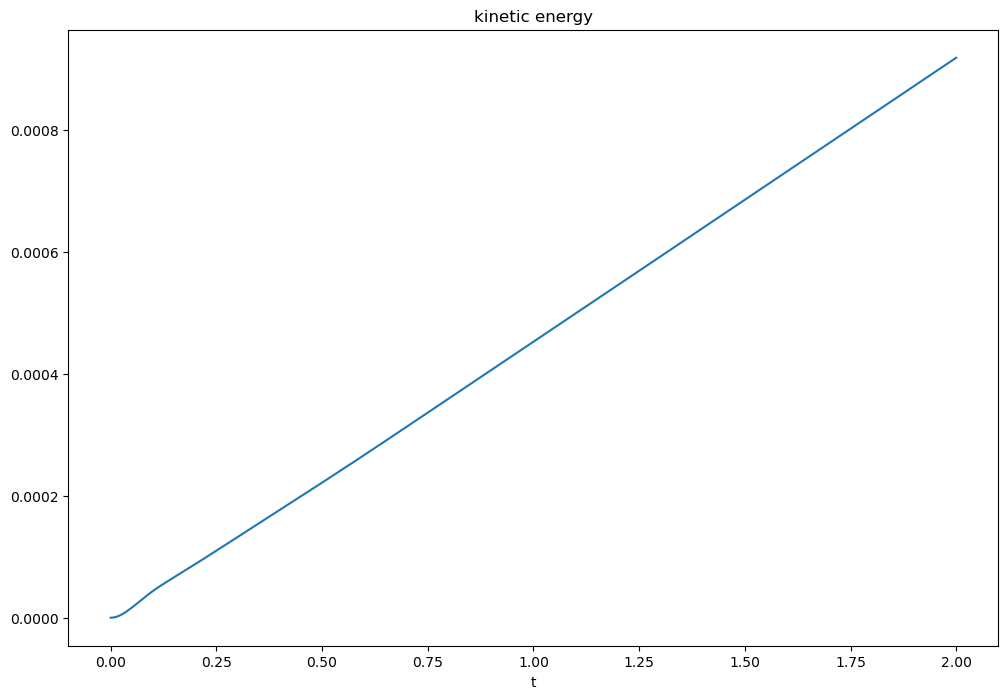

In [124]:
data = np.loadtxt("./sod001/time.txt", skiprows=1)
t_list = data[:,0]
KE_list = data[:,1]
# plot kinetic energy of the particles
plt.figure(figsize = (12,8))
plt.plot(t_list, KE_list)
plt.title("kinetic energy")
plt.xlabel("t")
plt.show()

In [125]:
nleft = 200
xmin = -0.5
xmax = 0.5
x0 = 0
L = xmax - xmin
rholeft = 1.0
rhoright = 0.1
cs = 0.1
nghost = 6
particles = setup(nleft, x0, xmin, xmax, rholeft, rhoright, cs, nghost)
particles = derivs(particles, nghost)

t0 = 0
tmax = 0.1
dt = 0.001
dtoutput = 0.01

t = t0

output_path = "./sod002/"
particles = sim(particles, nghost, t0, tmax, dt, dtoutput, output_path)

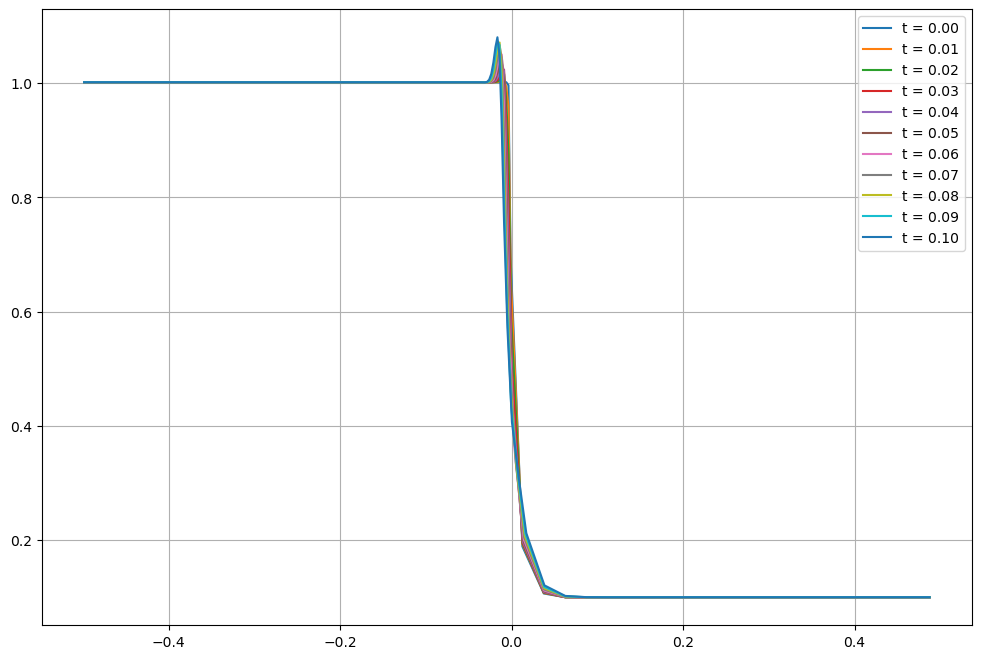

In [126]:
plt.figure(figsize = (12,8))
output_path = "./sod002/"
for i in range(11):
    filename = output_path+"output."+ str(i).zfill(5) + ".txt"
    t, particles = read_particles(filename)
    act_par = particles[nghost:-nghost]
    plt.plot(act_par[:, X1], act_par[:, DEN], label = "t = "+ format(t, ".2f"))
plt.grid()
plt.legend()
plt.show()